In [1]:
%matplotlib inline

import Levenshtein as L
import umap
import pandas as pd
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv('../data/train_multilabel.data')
df["T1D"] = 0
df.head()

,index,donor,cell_clono_cdr3_aa,TRA,TRB,VTEHDTLLY-IE-1-CMV,KTWGQYWQV-gp100-Cancer,ELAGIGILTV-MART-1-Cancer,CLLWSFQTSA-Tyrosinase-Cancer,IMDQVPFSV-gp100-Cancer,...,RAKFKQLL-BZLF1-EBV,ELRRKMMYM-IE-1-CMV,FLRGRAYGL-EBNA-3A-EBV,SLEGGGLGY-NC,STEGGGLAY-NC,ALIAPVHAV-NC,AYSSAGASI-NC,GPAESAAGL-NC,AAKGRGAAL-NC,T1D
0,AAACCTGAGAGGGATA-8,donor1,TRA:CAASGYGNTGRRALTF;TRB:CASSQDPAGGYNEQFF,CAASGYGNTGRRALTF,CASSQDPAGGYNEQFF,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAACCTGAGAGTGAGA-23,donor1,TRA:CAAHLSNFGNEKLTF;TRB:CATSRDRGHGDTIYF,CAAHLSNFGNEKLTF,CATSRDRGHGDTIYF,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACCTGAGATCCTGT-25,donor1,TRA:CASGGSNYKLTF;TRB:CASAVGLTYNEQFF,CASGGSNYKLTF,CASAVGLTYNEQFF,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,AAACCTGAGATCTGAA-26,donor1,TRA:CAEGGNTGKLIF;TRB:CASSPGGLAGADTQYF,CAEGGNTGKLIF,CASSPGGLAGADTQYF,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACCTGAGCGATTCT-39,donor1,TRA:CAVREDTGGFKTIF;TRB:CSARDPVLRQGRYEQYF,CAVREDTGGFKTIF,CSARDPVLRQGRYEQYF,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_mcpas = pd.read_csv("../data/McPAS-TCR.csv")
df_mcpas = df_mcpas.loc[(df_mcpas["Pathology"] == "Diabetes Type 1") & 
                        (df_mcpas["Species"] == "Human") & 
                        (df_mcpas["CDR3.beta.aa"].str.find("#") < 0) & 
                        (df_mcpas["CDR3.beta.aa"].str.find("*") < 0), 
                        ["CDR3.alpha.aa", "CDR3.beta.aa"]].reset_index(drop=True)
df_mcpas.columns = ["TRA", "TRB"]

df = pd.read_csv('../data/train_multilabel.data')
df["T1D"] = False
df_mcpas["T1D"] = True
df_new = pd.concat([df, df_mcpas])[["TRA", "TRB", "T1D"]].reset_index(drop=True)
df_new.to_csv("../data/train_t1d.data")
df_new

In [3]:
df = pd.read_csv('../data/train_multilabel.data')
sequences = df['TRB']

seq = pd.Series(sequences)
print("old:", len(seq)) 
seq = seq[(seq.str.len() >= 9) & (seq.str.len() <= 19)]
ind = seq.index
seq = seq.reset_index(drop=True)
print("new:", len(seq)) 

seq = seq.str.slice(start=2, stop=-2)
neg = list(set(seq))

df_mcpas = pd.read_csv("../data/McPAS-TCR.csv")
seq = df_mcpas.loc[(df_mcpas["Pathology"] == "Diabetes Type 1") & (df_mcpas["Species"] == "Human"), "CDR3.beta.aa"]
seq = seq.str.slice(start=2, stop=-2)
pos = list(set(seq))

print(len(neg), len(pos))

old: 41922
new: 41500
37571 885


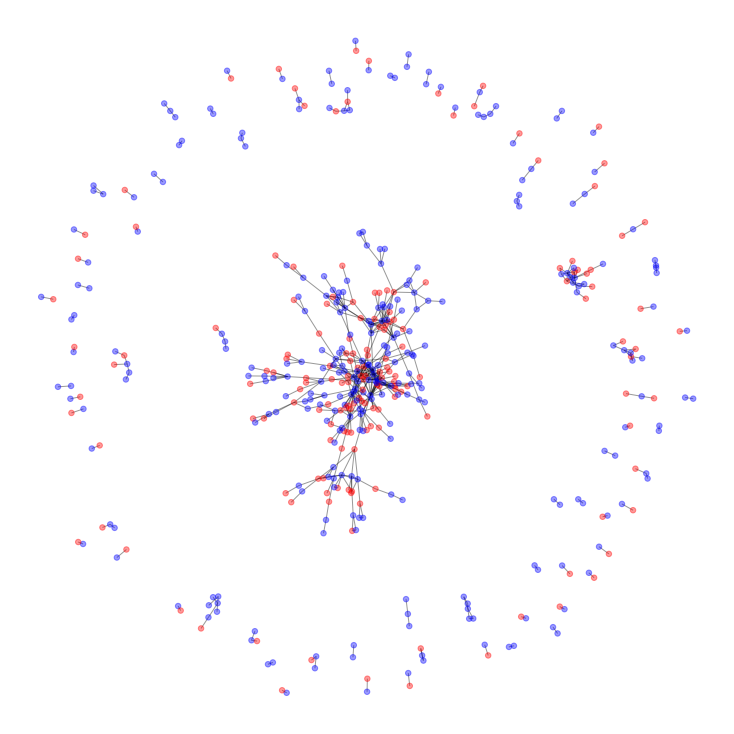

In [4]:
N = 2000
N = min(N, min(len(neg), len(pos)))
LEV_DIST = 2

# don't judge
new_neg = list(np.array(neg)[np.random.choice(len(neg), N, replace=False)])
new_pos = list(np.array(pos)[np.random.choice(len(pos), N, replace=False)])


G = nx.Graph()

for i in range(len(new_pos)):
    for j in range(len(new_neg)):
        dist_val = L.distance(new_pos[i], new_neg[j])
        
        if dist_val <= LEV_DIST:
            G.add_edge("P"+str(i), "N"+str(j))
            
for i in range(len(new_pos) - 1):
    for j in range(i+1, len(new_pos)):
        dist_val = L.distance(new_pos[i], new_pos[j])
        
        if dist_val <= LEV_DIST:
            G.add_edge("P"+str(i), "P"+str(j))

        
plt.figure(num=None, figsize=(10, 10))
nx.draw_spring(G, node_size=30, node_color = ["red" if node.startswith("N") else "blue" for node in G.nodes], alpha=.4)

In [8]:
df_mcpas = pd.read_csv("../data/McPAS-TCR.csv")
df_mcpas = df_mcpas.loc[(df_mcpas["Pathology"] == "Rheumatoid Arthritis (RA)") & 
                        (df_mcpas["Species"] == "Human") & 
                        (df_mcpas["CDR3.beta.aa"].str.find("#") < 0) & 
                        (df_mcpas["CDR3.beta.aa"].str.find("*") < 0), 
                        ["CDR3.alpha.aa", "CDR3.beta.aa"]].reset_index(drop=True)
df_mcpas.columns = ["TRA", "TRB"]
df_mcpas

,TRA,TRB
0,NaN,CAGSSASLYEQYF
1,NaN,CAIGEGTEAF
2,NaN,CAIGKGQAINTGELF
3,NaN,CAIRDRGDTQYF
4,NaN,CAISESNRGYEQYF
...,...,...
267,NaN,CSVVDSHSYNEQF
268,NaN,CSVVHSAPAQETQYF
269,NaN,CSVVQALYNEQF
270,NaN,SYSGQVSYEQYF


In [9]:
# Multiple sclerosis (MS)
# Rheumatoid Arthritis (RA)
df_mcpas = pd.read_csv("../data/McPAS-TCR.csv")
df_mcpas = df_mcpas.loc[(df_mcpas["Pathology"] == "Multiple sclerosis (MS)") & 
                        (df_mcpas["Species"] == "Human") & 
                        (df_mcpas["CDR3.beta.aa"].str.find("#") < 0) & 
                        (df_mcpas["CDR3.beta.aa"].str.find("*") < 0), 
                        ["CDR3.alpha.aa", "CDR3.beta.aa"]].reset_index(drop=True)
df_mcpas.columns = ["TRA", "TRB"]

df = pd.read_csv('../data/train_multilabel.data')
df["MS"] = False
df_mcpas["MS"] = True
df_new = pd.concat([df, df_mcpas])[["TRA", "TRB", "MS"]].reset_index(drop=True)
df_new.to_csv("../data/train_ms.data")
df_new

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,TRA,TRB,MS
0,CAASGYGNTGRRALTF,CASSQDPAGGYNEQFF,False
1,CAAHLSNFGNEKLTF,CATSRDRGHGDTIYF,False
2,CASGGSNYKLTF,CASAVGLTYNEQFF,False
3,CAEGGNTGKLIF,CASSPGGLAGADTQYF,False
4,CAVREDTGGFKTIF,CSARDPVLRQGRYEQYF,False
...,...,...,...
42033,NaN,CAWRSTGGIGDTQYF,True
42034,NaN,CAWSATGATDTQYF,True
42035,NaN,CRARAYFPE,True
42036,NaN,CSARTNRGYTF,True


In [12]:
# Multiple sclerosis (MS)
# Rheumatoid Arthritis (RA)
df_mcpas = pd.read_csv("../data/McPAS-TCR.csv")
df_mcpas = df_mcpas.loc[(df_mcpas["Pathology"] == "Rheumatoid Arthritis (RA)") & 
                        (df_mcpas["Species"] == "Human") & 
                        (df_mcpas["CDR3.beta.aa"].str.find("#") < 0) & 
                        (df_mcpas["CDR3.beta.aa"].str.find("*") < 0), 
                        ["CDR3.alpha.aa", "CDR3.beta.aa"]].reset_index(drop=True)
df_mcpas.columns = ["TRA", "TRB"]

df = pd.read_csv('../data/train_multilabel.data')
df["RA"] = False
df_mcpas["RA"] = True
df_new = pd.concat([df, df_mcpas])[["TRA", "TRB", "RA"]].reset_index(drop=True)
df_new.to_csv("../data/train_ra.data")
df_new

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,TRA,TRB,RA
0,CAASGYGNTGRRALTF,CASSQDPAGGYNEQFF,False
1,CAAHLSNFGNEKLTF,CATSRDRGHGDTIYF,False
2,CASGGSNYKLTF,CASAVGLTYNEQFF,False
3,CAEGGNTGKLIF,CASSPGGLAGADTQYF,False
4,CAVREDTGGFKTIF,CSARDPVLRQGRYEQYF,False
...,...,...,...
42189,NaN,CSVVDSHSYNEQF,True
42190,NaN,CSVVHSAPAQETQYF,True
42191,NaN,CSVVQALYNEQF,True
42192,NaN,SYSGQVSYEQYF,True
